# Imports

In [1]:
!pip install -q wurlitzer
!pip install -q --upgrade keras-cv tensorflow
!pip install -q --upgrade keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires tensorflow~=2.15.0, but you have tensorflow 2.16.1 which is incompatible.
tensorflow-text 2.15.0 requires tensorflow<2.16,>=2.15.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.16.1 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires tensorflow~=2.15.0, but you have tensorflow 2.16.1 which is incompatible.
tensorflow-text 2.15.0 requires tensorflow<2.16,>=2.15.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow

In [2]:
import tensorflow as tf
import keras
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

print('running tf: ', tf.__version__)
print('running keras: ', tf.__version__)

running tf:  2.16.1
running keras:  2.16.1


In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "jax" or "torch"!

# Config

In [4]:
DEBUG = False
input_size = 224
num_frames = 32
batch_size = 2  
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data Loading

In [5]:
def read_frames_from_folder(folder_path):
    folder_path = folder_path.numpy().decode('utf-8')
    # Get list of all frame files
    frame_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')])
    
    # Take the last num_frames frames if there are more frames
    if len(frame_files) > num_frames:
        frame_files = frame_files[-num_frames:]
    
    frames = []
    for frame_file in frame_files:
        img = image.load_img(frame_file, target_size=(input_size, input_size))
        img_array = image.img_to_array(img)
        frames.append(img_array)
    
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)

    # If fewer than num_frames, pad with zeros
    if len(frames) < num_frames:
        padding = tf.zeros((num_frames - len(frames), input_size, input_size, 3), dtype=tf.float32)
        frames = tf.concat([frames, padding], axis=0)
    return frames

def load_video_from_folder(file_path, label):
    video = tf.py_function(func=read_frames_from_folder, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frames, input_size, input_size, 3])
    return video, tf.cast(label, dtype=tf.float32)

def create_dataset(file_paths, labels, shuffle_buffer_size=None):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    # shuffle training data
    if shuffle_buffer_size:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
    dataset = dataset.map(load_video_from_folder, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


In [6]:
# Paths to your data
freeway_train_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/freeway/train'
road_train_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/road/train'
freeway_train_csv = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/freeway_train.csv'
road_train_csv = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/road_train.csv'

# Read CSV files
freeway_df = pd.read_csv(freeway_train_csv)
road_df = pd.read_csv(road_train_csv)

# Add the directory path to the file names
freeway_df['file_name'] = freeway_df['file_name'].apply(lambda x: os.path.join(freeway_train_path, x))
road_df['file_name'] = road_df['file_name'].apply(lambda x: os.path.join(road_train_path, x))

# Combine dataframes
all_df = pd.concat([freeway_df, road_df])

if DEBUG:
    all_df = all_df[:20]

In [7]:
# Split into train and validation sets
train_df, val_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['risk'])

# Create datasets
train_dataset = create_dataset(train_df['file_name'].values, train_df['risk'].values, shuffle_buffer_size=len(train_df))
val_dataset = create_dataset(val_df['file_name'].values, val_df['risk'].values)

In [8]:
print('Train Dataset: ', len(train_dataset))
print('Validation Dataset: ', len(val_dataset))

Train Dataset:  144
Validation Dataset:  36


### Sanity Check

In [9]:
# Example: Iterate through the train dataset
for videos, labels in train_dataset.take(1):
    print(videos.shape, labels.shape)

# Example: Iterate through the validation dataset
for videos, labels in val_dataset.take(1):
    print(videos.shape, labels.shape)

(2, 32, 224, 224, 3) (2,)
(2, 32, 224, 224, 3) (2,)


### Plot the Data

In [10]:
# def plot_sample_frames(dataset, num_samples=3, frames_to_plot=5):
#     """
#     Plots a few frames of sample videos from the dataset along with their labels.

#     Args:
#     dataset: tf.data.Dataset - The dataset containing video frames and labels.
#     num_samples: int - Number of sample videos to plot.
#     frames_to_plot: int - Number of frames to plot from each sample video.
#     """
#     # Take num_samples from the dataset
#     for videos, labels in dataset.take(num_samples):
#         # Convert tensors to numpy arrays
#         videos = videos.numpy()
#         labels = labels.numpy()
        
#         # Iterate over each sample in the batch
#         for i in range(videos.shape[0]):
#             fig, axes = plt.subplots(1, frames_to_plot, figsize=(15, 5))
#             fig.suptitle(f'Sample {i+1} - Label: {int(labels[i])}', fontsize=16)
            
#             # Plot a few frames from the sample video
#             for j in range(frames_to_plot):
#                 if j < videos.shape[1]:
#                     frame = videos[i, j]
#                     axes[j].imshow(frame.astype(np.uint8))
#                     axes[j].axis('off')
            
#             plt.show()

# # Example usage:
# # Plot a few frames of 3 sample videos from the train dataset
# plot_sample_frames(train_dataset, num_samples=3, frames_to_plot=5)


# Model

In [11]:
from keras_cv.models import VideoSwinBackbone
from keras_cv.models import VideoClassifier

In [12]:
def vswin_tiny():
    backbone=VideoSwinBackbone(
        input_shape=(num_frames, input_size, input_size, 3), 
        window_size=[8, 7, 7],
        embed_dim=128,
        depths=[2, 2, 18, 2],
        num_heads=[4, 8, 16, 32],
        include_rescaling=True, 
    )
    backbone.load_weights(
        '/kaggle/input/videoswin/keras/base/1/videoswin_base_kinetics400_imagenet22k.weights.h5'
    )
    backbone.trainable = False
    keras_model = VideoClassifier(
        backbone=backbone,
        num_classes=2,
        activation=None,
        pooling='avg',
    )
    return keras_model

In [13]:
model = vswin_tiny()

## Optimize & Compile

In [14]:
def lrfn(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

def get_lr_callback(batch_size=16):
#     lr_start   = 0.000005
#     lr_max     = 0.000003 * batch_size
#     lr_min     = 0.000001
#     lr_ramp_ep = 5
#     lr_sus_ep  = 0
#     lr_decay   = 0.3
       
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

Learning rate schedule: 0.0005 to 0.028 to 0.000281


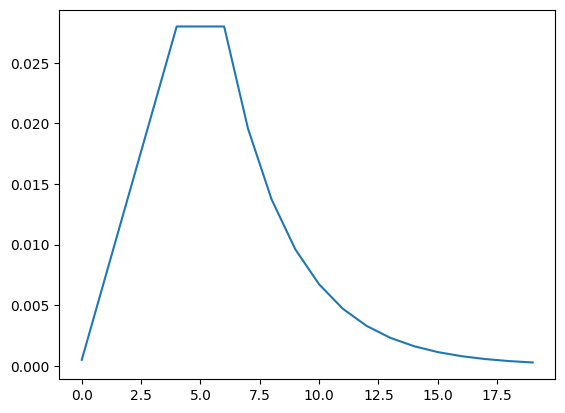

In [15]:
EPOCHS = 20
lr_start   = 0.0005
lr_max     = 0.002 * batch_size * 7
lr_min     = 0.00001
lr_ramp_ep = 4
lr_sus_ep  = 2
lr_decay   = 0.7

rng = [i for i in range(8 if EPOCHS<8 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(nesterov=False),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    ],
)

## Train Model

In [17]:
# ModelCheckpoint callback - to save best model from every training
checkpoint = keras.callbacks.ModelCheckpoint("best_model.keras", 
                                                save_best_only=True, 
                                                save_weights_only=False,
                                                verbose=1,
                                                monitor='val_loss', 
                                                mode='min')

csv_logger = tf.keras.callbacks.CSVLogger('history.csv')

learning_rate_reduction= keras.callbacks.ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 

# callbacks = [checkpoint, learning_rate_reduction]

callbacks = [checkpoint, csv_logger, get_lr_callback()]

In [18]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
#     steps_per_epoch=len(train_df) // batch_size,
#     validation_steps=len(test_df) // batch_size,
    epochs=EPOCHS,
    callbacks=callbacks,

)

Epoch 1/20


I0000 00:00:1719079112.479664      78 service.cc:145] XLA service 0x7b406c01a860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719079112.479712      78 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1719079246.952627      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5936 - loss: 0.7539
Epoch 1: val_loss improved from inf to 0.65545, saving model to best_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 1383s 9s/step - accuracy: 0.5938 - loss: 0.7536 - val_accuracy: 0.7361 - val_loss: 0.6555 - learning_rate: 5.0000e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6315 - loss: 0.8871
Epoch 2: val_loss improved from 0.65545 to 0.60092, saving model to best_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 1116s 8s/step - accuracy: 0.6318 - loss: 0.8868 - val_accuracy: 0.6806 - val_loss: 0.6009 - learning_rate: 0.0074
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7200 - loss: 0.9253
Epoch 3: val_loss did not improve from 0.60092
144/144 ━━━━━━━━━━━━━━━━━━━━ 1112s 8s/step - accuracy: 0.7197 - loss: 0.9268 - val_accuracy: 0.7083 - val_loss: 0.7902 - learning_rate: 0.0143
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6647 - loss: 1.4373
Epoch 4: val_loss did not

In [19]:
model.save('zero-model.keras')

## Plots

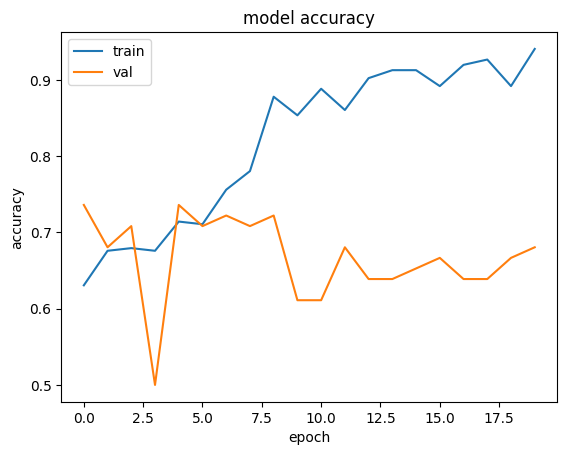

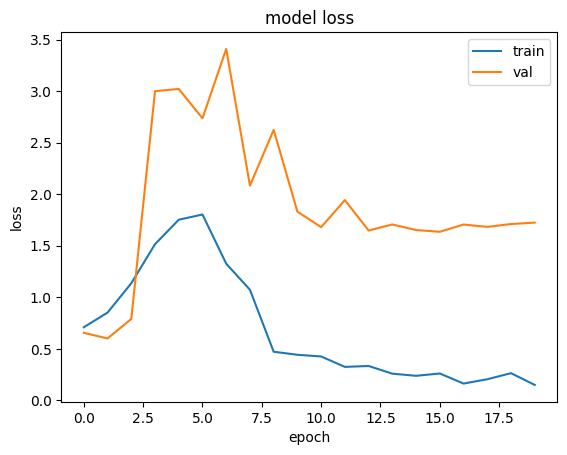

In [20]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()